In [60]:
import numpy as np
from matplotlib import pyplot as plt
import mne
mne.set_log_level(verbose=None)
import tensorflow as tf
import os
import re
from tqdm import tqdm
import torch

from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy,CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall, CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [61]:
N_CLASSES = 4
N_CHANNELS = 25
N_SAMPLES = 448

BCICIV_PATH = "/kaggle/input/eegpreprocessed/pt_bciciv"
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2 

FIRST_SPLIT = 0.12
SECOND_SPLIT = 0.15

EPOCHS = 200
LEARNING_RATE = 1e-3
MIN_DELTA = 1e-5
PATIENCE = 20

In [62]:
# Already sampled / preprocessed
def load_pt_data():
    data, labels, users = [], [], []
    for filename in tqdm(os.listdir(BCICIV_PATH)):
        f = os.path.join(BCICIV_PATH, filename)
        x, y, u = torch.load(f)
        data.append(x)
        labels.append(y)
        users.append(u)
    return np.array(data), np.array(labels), np.array(users)

def split_data(preprocessed_data, final_labels, final_user_idx):
    split = StratifiedShuffleSplit(n_splits=2, test_size=FIRST_SPLIT, random_state=0)
    for x_index, test_index in split.split(preprocessed_data, final_user_idx):
        X, X_test = preprocessed_data[x_index], preprocessed_data[test_index]
        y, y_test = final_labels[x_index], final_labels[test_index]
        users, users_test = final_user_idx[x_index], final_user_idx[test_index]
#     print(X.shape, X_test.shape, y.shape, y_test.shape)
#     print(np.unique(users, return_counts=True), np.unique(users_test, return_counts=True))
    split = StratifiedShuffleSplit(n_splits=2, test_size=SECOND_SPLIT, random_state=0)
    for train_index, valid_index in split.split(X, users):
        X_train, X_valid = X[train_index], X[valid_index] 
        y_train, y_valid = y[train_index], y[valid_index]
        users_train, users_valid = users[train_index], users[valid_index]
#     print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
#     print(np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True))

    return X_train, y_train, X_valid, y_valid, X_test, y_test

def one_hot_data(y_train, y_valid, y_test):
    y_train = tf.one_hot(y_train, depth=N_CLASSES, axis=0)
    y_valid = tf.one_hot(y_valid, depth=N_CLASSES, axis=0)
    y_test = tf.one_hot(y_test, depth=N_CLASSES, axis=0)
    return tf.transpose(y_train), tf.transpose(y_valid), tf.transpose(y_test)

def make_tf_dataset(X_train, y_train, X_valid, y_valid, X_test, y_test):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    valid_dataset = valid_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)

    return train_dataset, valid_dataset, test_dataset

In [63]:
data = load_pt_data()
X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(data[0], data[1], data[2])
y_train, y_valid, y_test = one_hot_data(y_train, y_valid, y_test)
train_dataset, valid_dataset, test_dataset = make_tf_dataset(X_train, y_train, X_valid, y_valid, X_test, y_test)

100%|██████████| 2592/2592 [00:03<00:00, 774.86it/s]


In [64]:
print(np.unique(y_train.numpy().argmax(axis=1), return_counts=True))
print(np.unique(y_valid.numpy().argmax(axis=1), return_counts=True))
print(np.unique(y_test.numpy().argmax(axis=1), return_counts=True))
print(X_train.max(), X_train.min(), X_train.mean(), X_train.std())

(array([0, 1, 2, 3]), array([483, 481, 490, 484]))
(array([0, 1, 2, 3]), array([85, 94, 77, 86]))
(array([0, 1, 2, 3]), array([80, 73, 81, 78]))
1.0 -1.0 0.019062353726686045 0.34398400833170356


In [65]:
def get_callbacks():
    return [
        # ModelCheckpoint(
        #     "best_eegnet.h5", save_best_only=True, monitor="val_loss"
        # ),
        # ReduceLROnPlateau(
        #     monitor="val_top_k_categorical_accuracy",
        #     factor=0.2,
        #     patience=2,
        #     min_lr=0.000001,
        # ),
        EarlyStopping(
            monitor="val_loss",
            min_delta=MIN_DELTA,
            patience=PATIENCE,
            verbose=1,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        ),
    ]

# https://arxiv.org/pdf/1611.08024.pdf
def EEGNet(n_classes, n_channels=64, n_samples=128, kernel_length=64, n_filters1=8, 
           n_filters2=16, depth_multiplier=2, norm_rate=0.25, dropout_rate=0.5, 
           dropoutType="Dropout"):

    if dropoutType == "SpatialDropout2D":
        dropoutType=SpatialDropout2D
    elif dropoutType == "Dropout":
        dropoutType=Dropout

    inputs = Input(shape=(n_channels, n_samples, 1))

    block1 = Conv2D(n_filters1, (1, kernel_length), padding="same", input_shape=(n_channels, n_samples, 1), use_bias=False)(inputs)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((n_channels, 1), use_bias=False, depth_multiplier=depth_multiplier, depthwise_constraint=max_norm(1.0))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation("elu")(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropout_rate)(block1)

    block2 = SeparableConv2D(n_filters2, (1, 16), use_bias=False, padding="same")(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation("elu")(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropout_rate)(block2)
    block2 = Flatten(name="flatten")(block2)

    classifier = Dense(n_classes, name="dense", kernel_constraint=max_norm(norm_rate))(block2)
    classifier = Activation("softmax", name="softmax")(classifier)

    model = Model(inputs=inputs, outputs=classifier) 

    optimizer = Adam(amsgrad=True, learning_rate=LEARNING_RATE)
    loss = CategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            CategoricalAccuracy(),
#             AUC(),
#             Precision(),
#             Recall(),
        ],
    )

    model.summary()

    return model

In [66]:
def plot_history_metrics(history):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

In [67]:
model = EEGNet(n_classes=N_CLASSES, n_channels=N_CHANNELS, n_samples=N_SAMPLES)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 25, 448, 1)]      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 448, 8)        512       
_________________________________________________________________
batch_normalization_9 (Batch (None, 25, 448, 8)        32        
_________________________________________________________________
depthwise_conv2d_3 (Depthwis (None, 1, 448, 16)        400       
_________________________________________________________________
batch_normalization_10 (Batc (None, 1, 448, 16)        64        
_________________________________________________________________
activation_6 (Activation)    (None, 1, 448, 16)        0         
_________________________________________________________________
average_pooling2d_6 (Average (None, 1, 112, 16)        0   

In [70]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=get_callbacks(),
    validation_data=valid_dataset,
#     class_weight=???,
)

Epoch 1/200
31/31 [==============================] - 2s 40ms/step - loss: 0.9944 - categorical_accuracy: 0.2466 - val_loss: 1.0293 - val_categorical_accuracy: 0.2749
Epoch 2/200
31/31 [==============================] - 1s 31ms/step - loss: 0.9620 - categorical_accuracy: 0.2730 - val_loss: 1.0184 - val_categorical_accuracy: 0.2749
Epoch 3/200
31/31 [==============================] - 1s 31ms/step - loss: 0.9799 - categorical_accuracy: 0.2621 - val_loss: 1.0146 - val_categorical_accuracy: 0.2749
Epoch 4/200
31/31 [==============================] - 1s 31ms/step - loss: 0.9917 - categorical_accuracy: 0.2792 - val_loss: 1.0117 - val_categorical_accuracy: 0.2749
Epoch 5/200
31/31 [==============================] - 1s 31ms/step - loss: 0.9955 - categorical_accuracy: 0.2642 - val_loss: 1.0043 - val_categorical_accuracy: 0.2749
Epoch 6/200
31/31 [==============================] - 1s 31ms/step - loss: 0.9884 - categorical_accuracy: 0.2828 - val_loss: 0.9948 - val_categorical_accuracy: 0.2749
Epoc

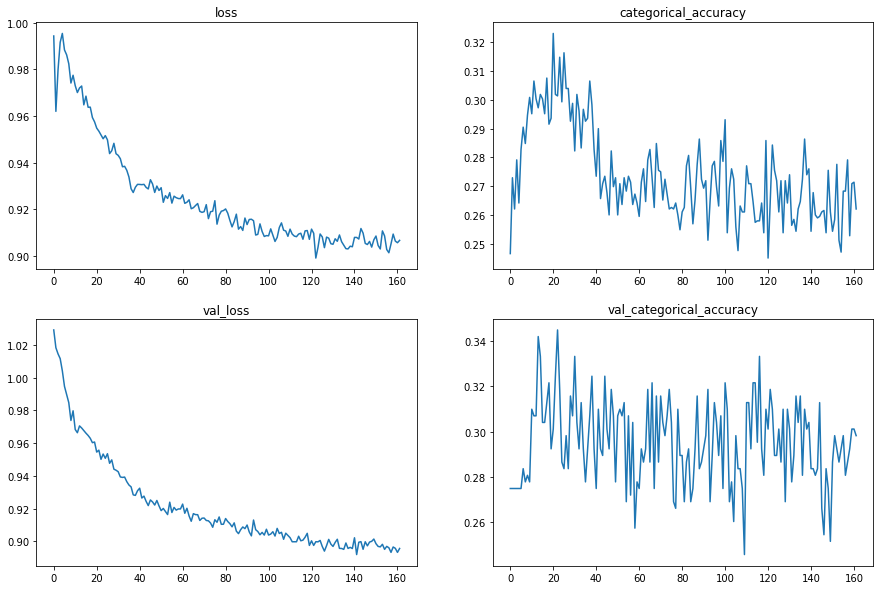

In [71]:
plot_history_metrics(history)

In [72]:
model.evaluate(X_test, y_test, batch_size=8)

39/39 [==============================] - 0s 3ms/step - loss: 0.8866 - categorical_accuracy: 0.2532


[0.8866202235221863, 0.2532051205635071]

In [73]:
model.predict(X_test)

array([[0.1023319 , 0.19156222, 0.27223784, 0.43386805],
       [0.08175947, 0.3369744 , 0.31874657, 0.26251954],
       [0.10712159, 0.3217605 , 0.29011923, 0.2809987 ],
       ...,
       [0.10209298, 0.30796587, 0.31154943, 0.27839172],
       [0.07918146, 0.35760763, 0.3186968 , 0.24451414],
       [0.08719029, 0.29937056, 0.2956289 , 0.31781027]], dtype=float32)

In [74]:
model.predict(X_test).shape

(312, 4)

In [75]:
y_test.numpy().shape

(312, 4)

In [76]:
np.where(model.predict(X_test).argmax(axis=1) == y_test.numpy().argmax(axis=1), 1, 0).mean()

0.2532051282051282

In [77]:
np.unique(model.predict(X_test).argmax(axis=1), return_counts=True)

(array([1, 2, 3]), array([153,  71,  88]))